# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [38]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0)
]

In [39]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

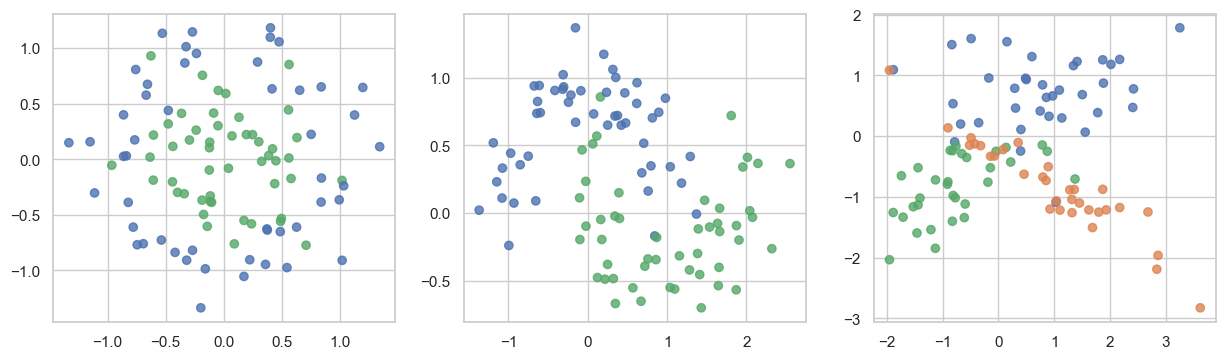

In [40]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [41]:
def plot_surface(classifier, features, labels):
    step_size = 0.01
    color_scheme = sns.color_palette(n_colors=len(np.unique(labels)))
    colormap = ListedColormap(color_scheme)
    
    x_range = [features[:, 0].min() - 1, features[:, 0].max() + 1]
    y_range = [features[:, 1].min() - 1, features[:, 1].max() + 1]
    
    x_grid, y_grid = np.meshgrid(
        np.arange(x_range[0], x_range[1], step_size),
        np.arange(y_range[0], y_range[1], step_size)
    )
    
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    
    grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]
    predictions = classifier.predict(grid_points)
    predictions = predictions.reshape(x_grid.shape)
    
    plt.contourf(x_grid, y_grid, predictions, cmap=colormap, alpha=0.3)
    plt.scatter(features[:, 0], features[:, 1], c=labels, cmap=colormap, 
                alpha=0.7, edgecolors=np.array(color_scheme)[labels], linewidths=2)
    plt.show()

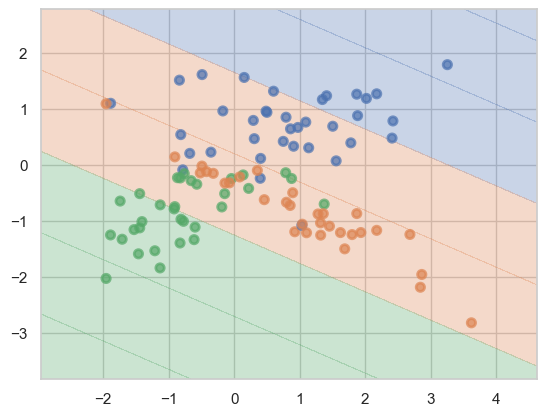

In [42]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

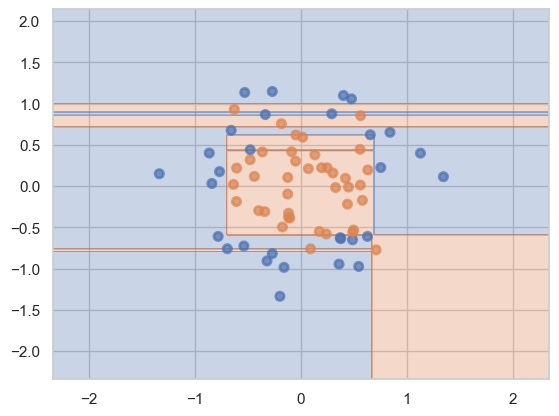

Dataset 1: Train accuracy = 1.0000, Test accuracy = 0.7333


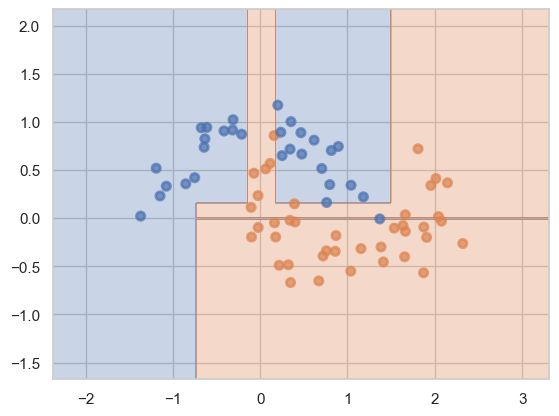

Dataset 2: Train accuracy = 1.0000, Test accuracy = 0.8667


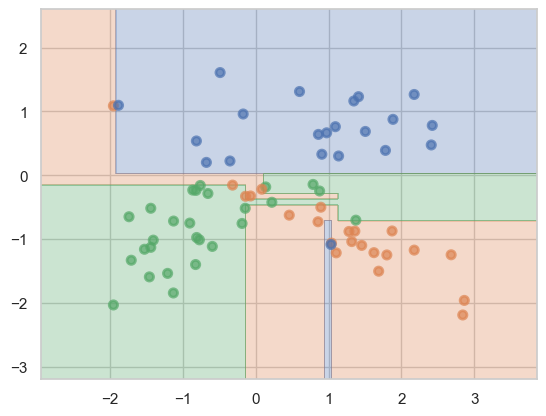

Dataset 3: Train accuracy = 1.0000, Test accuracy = 0.8333


In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def train_and_evaluate_dataset(X_data, y_data, dataset_num):
    X_tr, X_te, y_tr, y_te = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_tr, y_tr)
    
    train_acc = accuracy_score(y_tr, dt_model.predict(X_tr))
    test_acc = accuracy_score(y_te, dt_model.predict(X_te))
    
    plot_surface(dt_model, X_tr, y_tr)
    print(f"Dataset {dataset_num}: Train accuracy = {train_acc:.4f}, Test accuracy = {test_acc:.4f}")

for idx, (X_data, y_data) in enumerate(datasets, 1):
    train_and_evaluate_dataset(X_data, y_data, idx)

__Ответ:__
Да, деревья сильно переобучились. На обучающей выборке accuracy = 1.0 для всех датасетов, а на тестовой заметно ниже (около 0.73-0.87). Границы разбиения получились слишком сложными, с множеством мелких областей, что говорит о запоминании шума.


__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

1: Train accuracy = 0.9143, Test accuracy = 0.8000


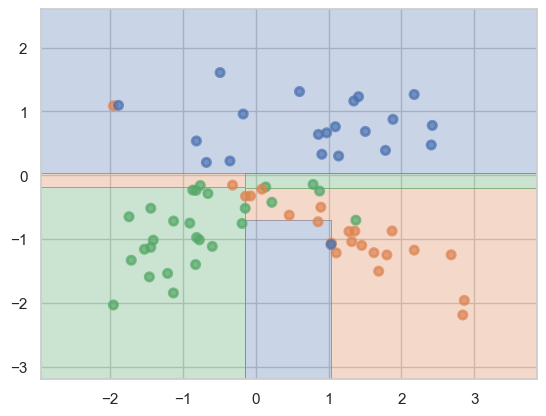

2: Train accuracy = 0.9143, Test accuracy = 0.8667


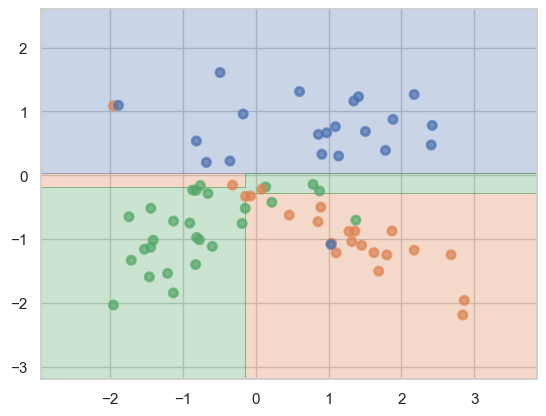

3: Train accuracy = 0.9143, Test accuracy = 0.7667


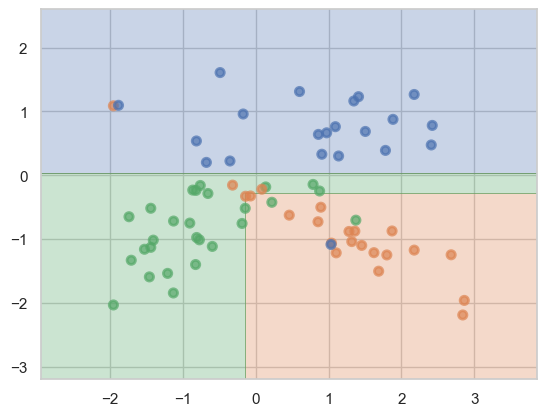

4: Train accuracy = 0.8857, Test accuracy = 0.7667


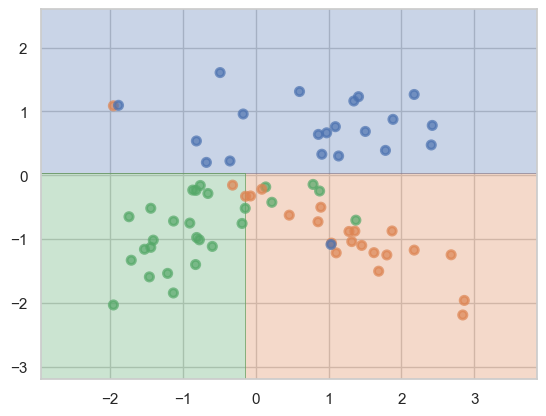

In [44]:
hyperparameter_configs = [
    {'max_depth': None, 'min_samples_leaf': 2},      
    {'max_depth': 3, 'min_samples_leaf': 2},        
    {'max_depth': 5, 'min_samples_leaf': 4},        
    {'max_depth': 3, 'min_samples_leaf': 20} 
]

dataset_features, dataset_labels = datasets[2]
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    dataset_features, dataset_labels, test_size=0.3, random_state=42
)

for config_idx, hyperparams in enumerate(hyperparameter_configs, 1):
    dt_classifier = DecisionTreeClassifier(
        max_depth=hyperparams['max_depth'],
        min_samples_leaf=hyperparams['min_samples_leaf'],
        random_state=42
    )
    dt_classifier.fit(X_train_split, y_train_split)
    
    train_predictions = dt_classifier.predict(X_train_split)
    test_predictions = dt_classifier.predict(X_test_split)
    
    training_accuracy = accuracy_score(y_train_split, train_predictions)
    testing_accuracy = accuracy_score(y_test_split, test_predictions)
    
    print(f"{config_idx}: Train accuracy = {training_accuracy:.4f}, Test accuracy = {testing_accuracy:.4f}")
    plot_surface(dt_classifier, X_train_split, y_train_split)

__Ответ:__

При увеличении max_depth границы становятся сложнее. Малая глубина (1-3) дает простые границы и может недообучать, большая (10+) переобучает.

Увеличение min_samples_leaf упрощает границы и снижает переобучение, но слишком большие значения могут недообучать.

Лучшие параметры для этого датасета: max_depth=3, min_samples_leaf=2 (train: 0.914, test: 0.867).

Для разных датасетов нужны разные параметры: для сложных границ (circles, moons) нужна умеренная регуляризация, для простых - сильная.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

Признак 1 (STG): найдено 74 порогов
Признак 2 (SCG): найдено 70 порогов
Признак 3 (STR): найдено 82 порогов
Признак 4 (LPR): найдено 79 порогов
Признак 5 (PEG): найдено 78 порогов


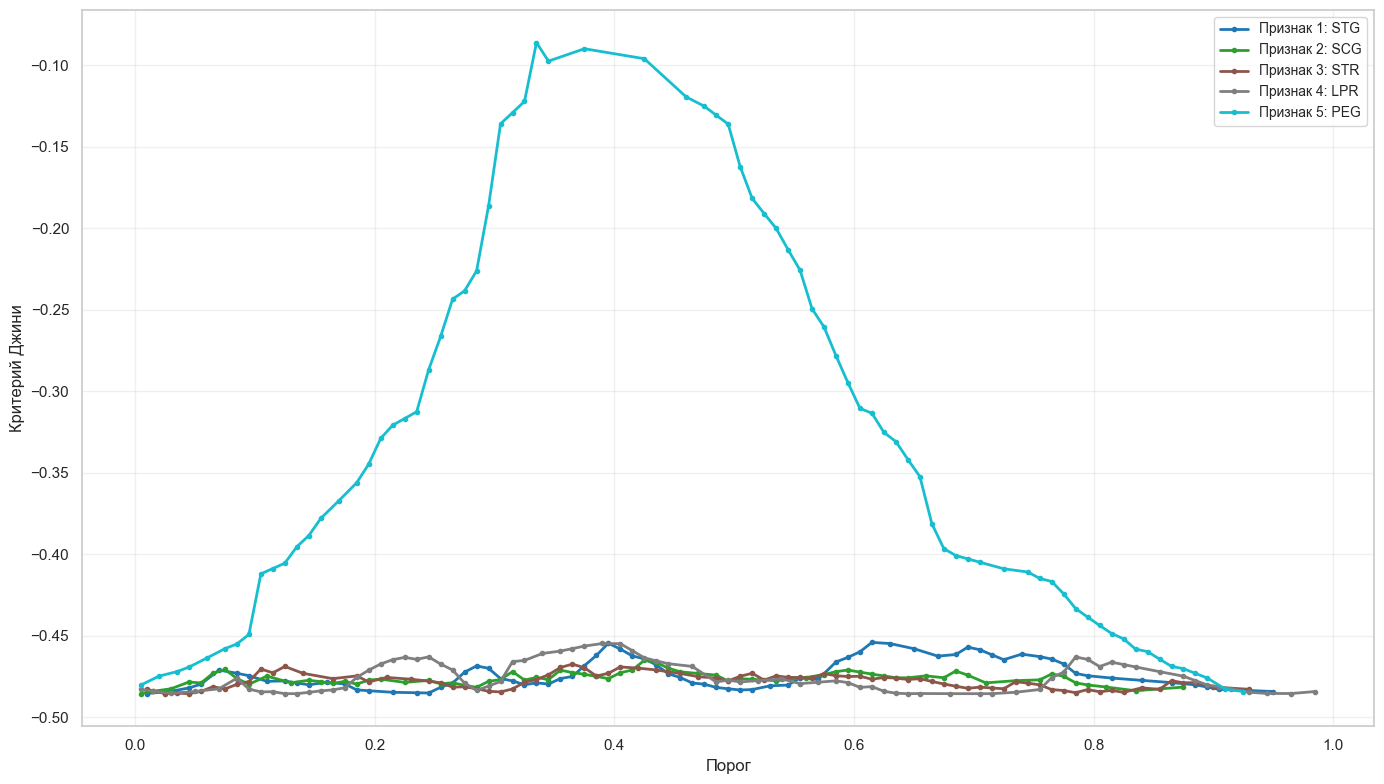

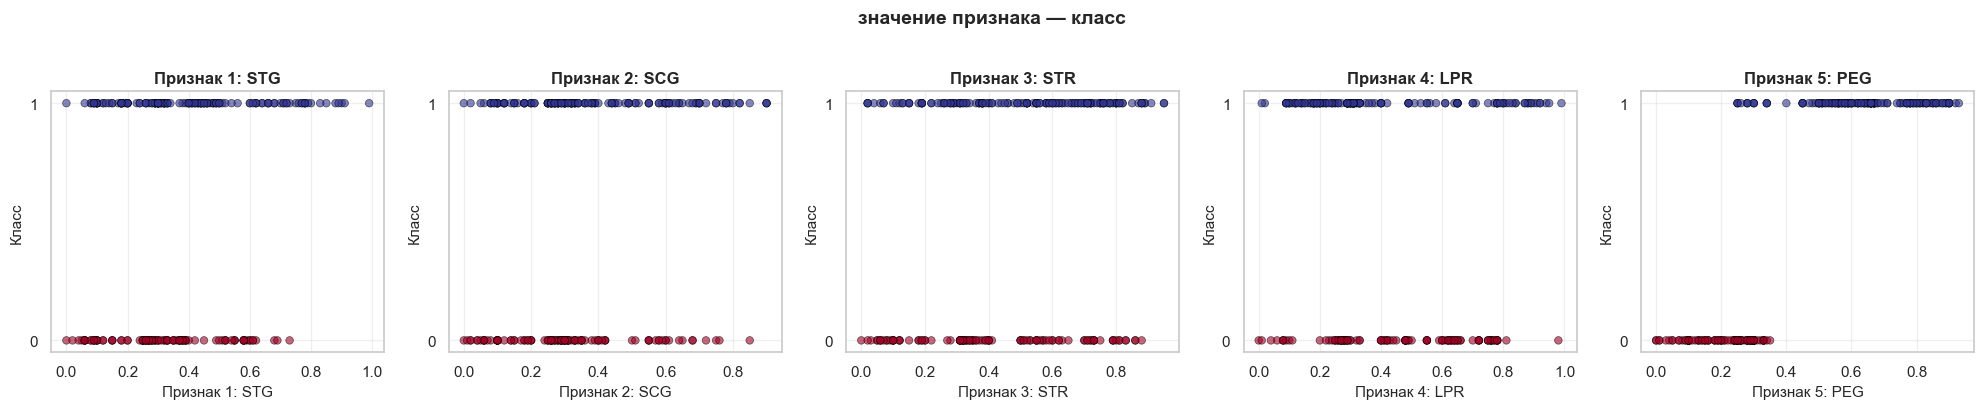

In [45]:
from hw2code import find_best_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

students_df = pd.read_csv('datasets/students.csv')

feature_matrix = students_df.iloc[:, :5].values
class_labels = students_df.iloc[:, -1].values
feature_column_names = students_df.columns[:5].tolist()

feature_analysis = {}

for feature_index, feature_name in enumerate(feature_column_names):
    current_feature = feature_matrix[:, feature_index]
    thresholds_array, gini_scores, optimal_threshold, optimal_gini = find_best_split(current_feature, class_labels)
    
    feature_analysis[feature_index] = {
        'name': feature_name,
        'thresholds': thresholds_array,
        'gini_scores': gini_scores,
        'feature_values': current_feature
    }
    
    print(f"Признак {feature_index+1} ({feature_name}): найдено {len(thresholds_array)} порогов")

fig_gini, ax_gini = plt.subplots(figsize=(14, 8))
color_map = plt.cm.tab10(np.linspace(0, 1, 5))

for idx, (feature_index, analysis_data) in enumerate(feature_analysis.items()):
    thresholds = analysis_data['thresholds']
    gini_values = analysis_data['gini_scores']
    
    if len(thresholds) > 0:
        ax_gini.plot(thresholds, gini_values, 
                    label=f'Признак {feature_index+1}: {analysis_data["name"]}', 
                    color=color_map[idx], linewidth=2, marker='o', markersize=3)

ax_gini.set_xlabel('Порог', fontsize=12)
ax_gini.set_ylabel('Критерий Джини', fontsize=12)
ax_gini.legend(loc='best', fontsize=10)
ax_gini.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig_scatter, axes_array = plt.subplots(1, 5, figsize=(20, 4))

for feature_index, analysis_data in feature_analysis.items():
    current_ax = axes_array[feature_index]
    feature_vals = analysis_data['feature_values']
    
    scatter_plot = current_ax.scatter(feature_vals, class_labels, c=class_labels, 
                                     cmap='RdYlBu', alpha=0.6, s=30, 
                                     edgecolors='black', linewidth=0.5)
    current_ax.set_xlabel(f'Признак {feature_index+1}: {analysis_data["name"]}', fontsize=11)
    current_ax.set_ylabel('Класс', fontsize=11)
    current_ax.set_title(f'Признак {feature_index+1}: {analysis_data["name"]}', 
                        fontsize=12, fontweight='bold')
    current_ax.set_yticks([0, 1])
    current_ax.grid(True, alpha=0.3)
    
fig_scatter.suptitle('значение признака — класс', 
                    fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**

1) По признаку с наилучшим критерием Джини (наименьшим по модулю, так как он отрицательный). Обычно это признак с самым выраженным максимумом на кривой.

2) Да, это согласуется с графиками: признак с хорошим визуальным разделением имеет лучший критерий Джини.

3) У хороших признаков кривая имеет четкий пик с высоким значением (близко к 0), что показывает наличие эффективных порогов разбиения.

4) У плохих признаков кривая плоская, без пиков, с низкими значениями. Это значит, что ни один порог не разделяет классы хорошо.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [46]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from hw2code import DecisionTree
import numpy as np
import pandas as pd

mushroom_df = pd.read_csv('datasets/agaricus-lepiota.data', header=None)

print(f"Размер данных: {mushroom_df.shape}")
print(f"Первые 5 строк:")
print(mushroom_df.head())

for col_idx in mushroom_df.columns:
    encoder = LabelEncoder()
    mushroom_df[col_idx] = encoder.fit_transform(mushroom_df[col_idx].astype(str))

target_col = mushroom_df.iloc[:, 0].values
features_matrix = mushroom_df.iloc[:, 1:].values

np.random.seed(42)
n_samples = len(target_col)
indices = np.arange(n_samples)
np.random.shuffle(indices)

split_idx = n_samples // 2
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

X_tr = features_matrix[train_indices]
X_te = features_matrix[test_indices]
y_tr = target_col[train_indices]
y_te = target_col[test_indices]


n_features = X_tr.shape[1]
mushroom_tree = DecisionTree(feature_types=['categorical'] * n_features)
mushroom_tree.fit(X_tr, y_tr)

predictions = mushroom_tree.predict(X_te)
test_accuracy = accuracy_score(y_te, predictions)

def calculate_max_depth(tree_node, current_level=0):
    if tree_node.get("type") == "terminal":
        return current_level
    left_subtree = tree_node.get("left_child", {})
    right_subtree = tree_node.get("right_child", {})
    left_max = calculate_max_depth(left_subtree, current_level + 1) if left_subtree else current_level
    right_max = calculate_max_depth(right_subtree, current_level + 1) if right_subtree else current_level
    return max(left_max, right_max)

max_tree_depth = calculate_max_depth(mushroom_tree._tree)

print("После операций:")
print(mushroom_df.head())
print(f"Accuracy на тестовой выборке: {test_accuracy:.6f}")
print(f"Максимальная глубина дерева: {max_tree_depth}")


Размер данных: (8124, 23)
Первые 5 строк:
  0  1  2  3  4  5  6  7  8  9   ... 13 14 15 16 17 18 19 20 21 22
0  p  x  s  n  t  p  f  c  n  k  ...  s  w  w  p  w  o  p  k  s  u
1  e  x  s  y  t  a  f  c  b  k  ...  s  w  w  p  w  o  p  n  n  g
2  e  b  s  w  t  l  f  c  b  n  ...  s  w  w  p  w  o  p  n  n  m
3  p  x  y  w  t  p  f  c  n  n  ...  s  w  w  p  w  o  p  k  s  u
4  e  x  s  g  f  n  f  w  b  k  ...  s  w  w  p  w  o  e  n  a  g

[5 rows x 23 columns]
После операций:
   0   1   2   3   4   5   6   7   8   9   ...  13  14  15  16  17  18  19  \
0   1   5   2   4   1   6   1   0   1   4  ...   2   7   7   0   2   1   4   
1   0   5   2   9   1   0   1   0   0   4  ...   2   7   7   0   2   1   4   
2   0   0   2   8   1   3   1   0   0   5  ...   2   7   7   0   2   1   4   
3   1   5   3   8   1   6   1   0   1   5  ...   2   7   7   0   2   1   4   
4   0   5   2   3   0   5   1   1   0   4  ...   2   7   7   0   2   1   0   

   20  21  22  
0   2   3   5  
1   3   2   1  


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

Исследование зависимости от max_depth...


Исследование зависимости от min_samples_split...
Исследование зависимости от min_samples_leaf...


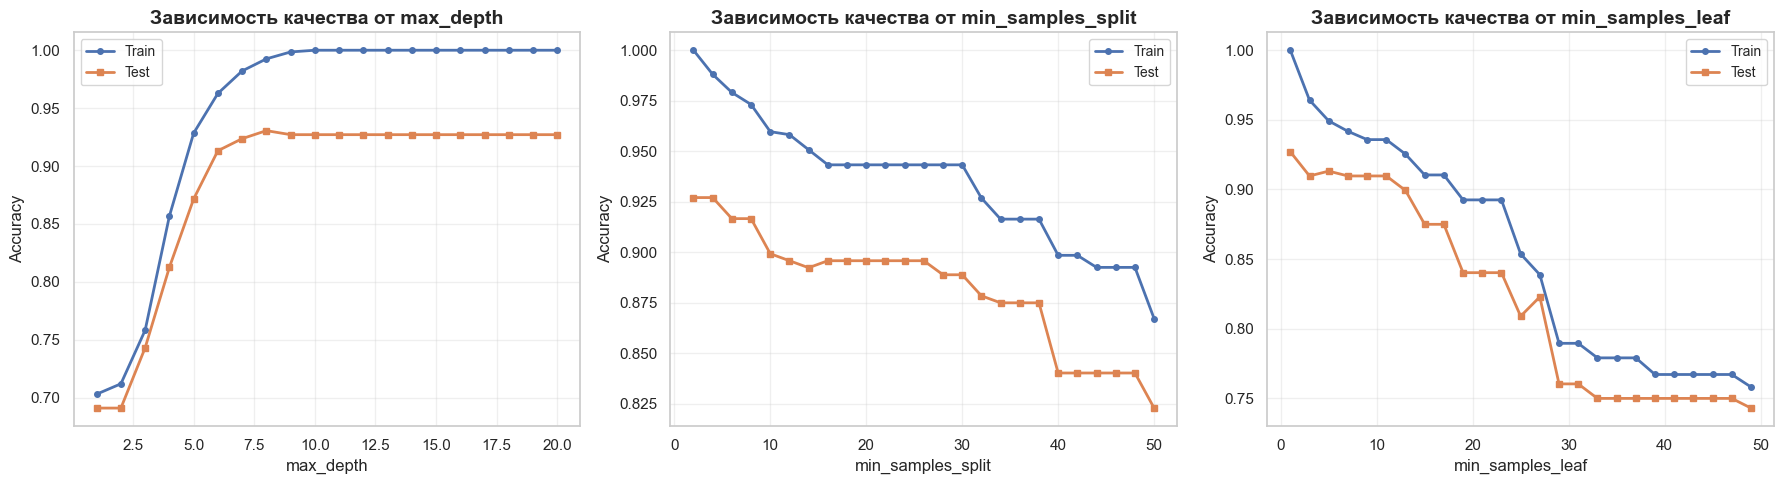


Лучшие результаты:
max_depth: Test accuracy = 0.9306 при max_depth = 8
min_samples_split: Test accuracy = 0.9271 при min_samples_split = 2
min_samples_leaf: Test accuracy = 0.9271 при min_samples_leaf = 1


In [47]:
ttt_dataset = pd.read_csv('datasets/tic-tac-toe-endgame.csv', skiprows=1, header=None)
X_features = ttt_dataset.iloc[:, :-1].values
y_target = ttt_dataset.iloc[:, -1].values

X_encoded = np.zeros_like(X_features, dtype=int)
for col_idx in range(X_features.shape[1]):
    encoder = LabelEncoder()
    X_encoded[:, col_idx] = encoder.fit_transform(X_features[:, col_idx].astype(str))

target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y_target)

X_tr, X_te, y_tr, y_te = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)

cat_feature_types = ['categorical'] * X_encoded.shape[1]

def evaluate_parameter_range(param_name, param_values, X_train, X_test, y_train, y_test, feature_types):
    train_accs = []
    test_accs = []
    for param_val in param_values:
        model_params = {param_name: param_val}
        dt = DecisionTree(feature_types=feature_types, **model_params)
        dt.fit(X_train, y_train)
        train_accs.append(accuracy_score(y_train, dt.predict(X_train)))
        test_accs.append(accuracy_score(y_test, dt.predict(X_test)))
    return train_accs, test_accs

print("Исследование зависимости от max_depth...")
depth_range = list(range(1, 21))
train_acc_depth, test_acc_depth = evaluate_parameter_range('max_depth', depth_range, X_tr, X_te, y_tr, y_te, cat_feature_types)

print("Исследование зависимости от min_samples_split...")
split_range = list(range(2, 51, 2))
train_acc_split, test_acc_split = evaluate_parameter_range('min_samples_split', split_range, X_tr, X_te, y_tr, y_te, cat_feature_types)

print("Исследование зависимости от min_samples_leaf...")
leaf_range = list(range(1, 51, 2))
train_acc_leaf, test_acc_leaf = evaluate_parameter_range('min_samples_leaf', leaf_range, X_tr, X_te, y_tr, y_te, cat_feature_types)

results_dict = {
    'max_depth': {'params': depth_range, 'train': train_acc_depth, 'test': test_acc_depth},
    'min_samples_split': {'params': split_range, 'train': train_acc_split, 'test': test_acc_split},
    'min_samples_leaf': {'params': leaf_range, 'train': train_acc_leaf, 'test': test_acc_leaf}
}

fig, ax_array = plt.subplots(1, 3, figsize=(18, 5))

for idx, (param_name, data) in enumerate(results_dict.items()):
    ax_array[idx].plot(data['params'], data['train'], 'o-', label='Train', linewidth=2, markersize=4)
    ax_array[idx].plot(data['params'], data['test'], 's-', label='Test', linewidth=2, markersize=4)
    ax_array[idx].set_xlabel(param_name, fontsize=12)
    ax_array[idx].set_ylabel('Accuracy', fontsize=12)
    ax_array[idx].set_title(f'Зависимость качества от {param_name}', fontsize=14, fontweight='bold')
    ax_array[idx].legend(fontsize=10)
    ax_array[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_results = {}
for param_name, data in results_dict.items():
    best_idx = np.argmax(data['test'])
    best_results[param_name] = {
        'value': data['params'][best_idx],
        'accuracy': data['test'][best_idx]
    }

print("\nЛучшие результаты:")
for param_name, result in best_results.items():
    print(f"{param_name}: Test accuracy = {result['accuracy']:.4f} при {param_name} = {result['value']}")

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [48]:
import importlib
import hw2code
importlib.reload(hw2code)

from hw2code import DecisionTree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd

def get_cv_mean(clf, X, y, n_splits=10):
    acc_scorer = make_scorer(accuracy_score)
    cv_scores = cross_val_score(clf, X, y, cv=n_splits, scoring=acc_scorer)
    return cv_scores.mean()

output_data = []

datasets_info = [
    {
        'name': 'mushrooms',
        'file': 'datasets/agaricus-lepiota.data',
        'X_cols': slice(1, None),
        'y_col': 0,
        'binary_transform': None
    },
    {
        'name': 'tic-tac-toe',
        'file': 'datasets/tic-tac-toe-endgame.csv',
        'X_cols': slice(None, -1),
        'y_col': -1,
        'binary_transform': None,
        'skiprows': 1
    },
    {
        'name': 'cars',
        'file': 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data',
        'X_cols': slice(None, -1),
        'y_col': -1,
        'binary_transform': {'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1}
    },
    {
        'name': 'nursery',
        'file': 'https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data',
        'X_cols': slice(None, -1),
        'y_col': -1,
        'binary_transform': {'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1}
    }
]

for ds_info in datasets_info:
    print("=" * 60)
    print(f"{datasets_info.index(ds_info) + 1}. {ds_info['name'].upper()} DATASET")
    print("=" * 60)
    
    try:
        if 'skiprows' in ds_info:
            df = pd.read_csv(ds_info['file'], header=None, skiprows=ds_info['skiprows'])
        else:
            df = pd.read_csv(ds_info['file'], header=None)
    except:
        print(f"Не удалось загрузить датасет {ds_info['name']}")
        continue
    
    X_raw = df.iloc[:, ds_info['X_cols']].values
    y_raw = df.iloc[:, ds_info['y_col']].values
    
    if ds_info['binary_transform']:
        y_binary = np.array([ds_info['binary_transform'].get(str(val), 0) for val in y_raw])
    else:
        le_y = LabelEncoder()
        y_binary = le_y.fit_transform(y_raw)
        print(f"Классы: {le_y.classes_}")
    
    X_encoded = np.zeros((X_raw.shape[0], X_raw.shape[1]), dtype=int)
    for col in range(X_raw.shape[1]):
        le = LabelEncoder()
        X_encoded[:, col] = le.fit_transform(X_raw[:, col].astype(str))
    
    print(f"Размер: {X_encoded.shape}")
    if ds_info['binary_transform']:
        print(f"Распределение классов: {np.bincount(y_binary)}")
    
    n_features = X_encoded.shape[1]
    feature_configs = [
        ('real', ['real'] * n_features, X_encoded),
        ('categorical', ['categorical'] * n_features, X_encoded),
        ('one-hot', None, None)
    ]
    
    results_row = {'Dataset': ds_info['name']}
    
    for config_name, feature_list, X_data in feature_configs:
        if config_name == 'one-hot':
            ohe_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            X_transformed = ohe_transformer.fit_transform(X_encoded)
            feature_list = ['real'] * X_transformed.shape[1]
            X_data = X_transformed
        
        model = DecisionTree(feature_types=feature_list)
        accuracy = get_cv_mean(model, X_data, y_binary, n_splits=10)
        results_row[f'DecisionTree ({config_name})'] = accuracy
        print(f"DecisionTree ({config_name}): {accuracy:.4f}")
    
    sklearn_clf = DecisionTreeClassifier(random_state=42)
    sklearn_acc = get_cv_mean(sklearn_clf, X_encoded, y_binary, n_splits=10)
    results_row['sklearn DecisionTreeClassifier'] = sklearn_acc
    print(f"sklearn DecisionTreeClassifier: {sklearn_acc:.4f}")
    
    output_data.append(results_row)

print("\n" + "=" * 60)
print("РЕЗУЛЬТАТЫ")
print("=" * 60)

summary_df = pd.DataFrame(output_data)
summary_df = summary_df.set_index('Dataset')
print("\nТаблица результатов (accuracy):")
print(summary_df.round(4))

1. MUSHROOMS DATASET
Классы: ['e' 'p']
Размер: (8124, 22)
DecisionTree (real): 0.9993
DecisionTree (categorical): 1.0000
DecisionTree (one-hot): 0.9996
sklearn DecisionTreeClassifier: 0.9604
2. TIC-TAC-TOE DATASET
Классы: ['negative' 'positive']
Размер: (958, 9)
DecisionTree (real): 0.4675
DecisionTree (categorical): 0.5425
DecisionTree (one-hot): 0.5446
sklearn DecisionTreeClassifier: 0.7717
3. CARS DATASET
Размер: (1728, 6)
Распределение классов: [1594  134]
DecisionTree (real): 0.9426
DecisionTree (categorical): 0.9675
DecisionTree (one-hot): 0.9195
sklearn DecisionTreeClassifier: 0.9427
4. NURSERY DATASET
Размер: (12960, 8)
Распределение классов: [4322 8638]
DecisionTree (real): 0.9997
DecisionTree (categorical): 0.9998
DecisionTree (one-hot): 0.9995
sklearn DecisionTreeClassifier: 0.9997

РЕЗУЛЬТАТЫ

Таблица результатов (accuracy):
             DecisionTree (real)  DecisionTree (categorical)  \
Dataset                                                        
mushrooms              

__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

1) Нет, ранжирование разное.

    В mushrooms лучший categorical (1.0000), так как признаки неупорядоченные категориальные, и специальный алгоритм разбиения работает лучше. Затем one-hot (0.9996), real (0.9993), sklearn (0.9604).

    В tic-tac-toe лучший sklearn (0.7717), так как в данных сложные паттерны, а sklearn лучше их обрабатывает. Затем one-hot (0.5446), categorical (0.5425), real (0.4675).

    В cars лучший categorical (0.9675), затем sklearn (0.9427), real (0.9426), one-hot (0.9195).

    В nursery все методы показывают очень высокую точность (0.9995-0.9998).

2) Случайность возникает из-за разных разбиений в кросс-валидации, порядка обработки признаков и различий между фолдами.

3) Для улучшения: использовать правильный тип признаков, добавить регуляризацию, использовать ансамбли, фиксировать random_state. 

Вставьте что угодно, описывающее ваши впечатления от этого задания:


![Впечатления от задания](goooool.png)
